Test q-profile, curvature, volume derivative and integraion. In order for this to work you will need to compile the `path/to/feltor/src/geometry_diag/geometry_diag` program inside "feltor". Then set the `FELTOR_PATH` variable in cell 1 here.

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import simplesimdb as simplesim

import pandas as pd
plt.rcParams.update({'font.size': 18})
pd.set_option('display.float_format', lambda x: '%.2e' % x)
FELTOR_PATH="../feltor" # path to the feltor library

In [2]:
# Create an inputfile for the geometry_diag.cpp program to plot an example grid and the delta function
def create_geometry_input() :
    with open ("compass_2X.json",'r') as f:
        params = json.load(f)
    geometry_diag_json = {
    "grid":
    {
        "n" : 3,
        "Nx" : 80,
        "Ny" : 80,
        "Nz" : 20,
        "npsi" : 3,
        "Npsi": 32,
        "Neta": 640,
        "scaleR" : [1.4, 1.3],
        "scaleZ" : [2, 2]
    },
    "boundary":
    {
        "wall":
        {
            "type" : "heaviside",
            "boundary" : 1.1,
            "alpha" : 0.2
        },
        "sheath":
        {
            "boundary" : 0.0625,
            "alpha" : 0.015625,
            "max_angle": 1e-3
        }
    },
    "diagnostics" : ["fsa", "q-profile"],
    "magnetic_field":
    {
        "input" : "params",
        "params": params
    },
    "width-factor" : 0.2
    }
    return geometry_diag_json

In [3]:
geometry_sim = simplesim.Manager( executable=FELTOR_PATH+"/src/geometry_diag/geometry_diag",
                              directory="Averages/geometry", filetype="nc")
# geometry_sim.delete_all()

Existing simulation 3c8de6...947083.nc
reference  0.08290014099839027
aligned  0.001194647997181164
$\varepsilon/h = 0.5$ 0.11777077599981567
Existing simulation 768d72...e4bb73.nc
$\varepsilon/h = 0.5$ 0.13071066599877668
Existing simulation 854d58...679159.nc
$\varepsilon/h = 0.5$ 0.09878129299977445


/tmp/ipykernel_7863/1383657837.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


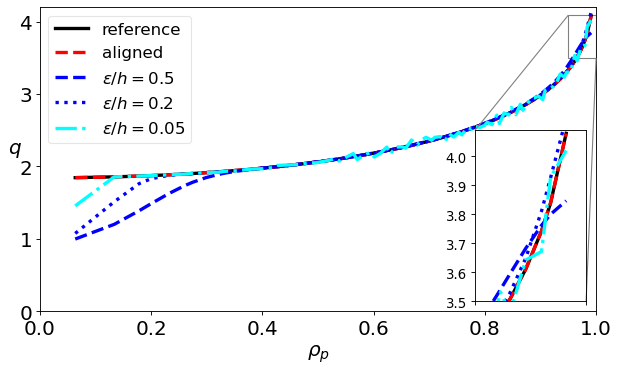

In [4]:
# plot q-profile for various methods
geometry_input = create_geometry_input()
with open ("compass_2X.json",'r') as f:
    params = json.load(f)
geometry_input["magnetic_field"]["params"] = params
geometry_input["width-factor"] = 0.5
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
frows = 1
fcols = 1

rho_p = ncin["rho_p"][:]
lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
rho = rho_p[:lcfs]
dvdpsip = ncin["dvdpsip"][:lcfs]
qprof_ana = ncin["q-profile"][:lcfs]

# for name, variable in ncin.variables.items():            
#     for attrname in variable.ncattrs():
#         print("{} -- {}".format(attrname, getattr(variable, attrname)))
R_0 = geometry_input["magnetic_field"]["params"]["R_0"]                              
                              
qprof_num_eta = 1./4./np.pi**2/R_0*dvdpsip* ncin["BFieldP_fsa"][:lcfs]
qprof_num_avg = ncin["q-profile-avg"][:lcfs]

fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.618*5,frows*5),dpi= 80, facecolor='w', edgecolor='k')
# fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1*7,frows*7),dpi= 80, facecolor='w', edgecolor='k')

im = ax.plot(rho, qprof_ana, color = 'k', ls='-', lw=3, label = 'reference') 
im = ax.plot(rho, qprof_num_eta, color = 'red', ls='--', lw=3, label="aligned") 
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls='--', lw=3, label=r"$\varepsilon/h = 0.5$") 
print( "reference ", getattr( ncin.variables["q-profile"], "time"))
print( "aligned ", getattr( ncin.variables["BFieldP_fsa"], "time"))
timings = [getattr( ncin.variables["q-profile-avg"], "time")]
print( r"$\varepsilon/h = 0.5$", timings[0] )

ncin.close()
##########################################
geometry_input["width-factor"] = 0.2
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg2 = ncin["q-profile-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg2, color = 'blue', ls=':', lw=3, label=r"$\varepsilon/h = 0.2$") 
timings.append(getattr( ncin.variables["q-profile-avg"], "time"))
print( r"$\varepsilon/h = 0.5$", timings[1])
##########################################
geometry_input["width-factor"] = .05
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg3 = ncin["q-profile-avg"][:lcfs]

im = ax.plot(rho, qprof_num_avg3, color = 'cyan', ls='-.', lw=3, label=r"$\varepsilon/h = 0.05$") 
timings.append(getattr( ncin.variables["q-profile-avg"], "time"))
print( r"$\varepsilon/h = 0.5$", timings[2])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper left',numpoints=1,ncol=1,
                   fontsize='small',framealpha=0.5)
ax.set_xlabel( r"$\rho_p$")
ax.set_xlim([0,1])
ax.set_ylabel( r"$q$",rotation=0)
ax.set_ylim(0,4.2)

axins = zoomed_inset_axes(ax, 4, loc='lower right')
axins.plot(rho, qprof_ana, color = 'k', ls='-', lw=3) 
axins.plot(rho, qprof_num_eta, color = 'red', ls='--', lw=3) 
axins.plot(rho, qprof_num_avg, color = 'blue', ls='--', lw=3) 
axins.plot(rho, qprof_num_avg2, color = 'blue', ls=':', lw=3) 
axins.plot(rho, qprof_num_avg3, color = 'cyan', ls='-.', lw=3) 
axins.set_xlim(0.95, 1)
axins.set_ylim(3.5, 4.09)
axins.tick_params(axis='both', which='major', labelsize=12)
axins.tick_params(axis='both', which='major', labelsize=12)
plt.setp(axins.get_xticklabels(), visible=False)
# plt.setp(axins.get_yticklabels(), visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.tight_layout()
plt.savefig( "q-profile.png", bbox_inches="tight")
plt.show()

Existing simulation 99e53b...234b9e.nc
aligned  0.001288377
$\varepsilon/h = 0.5$ 0.11866945250000001
Existing simulation 52f02d...092fea.nc
$\varepsilon/h = 0.2$ 0.1319335935
Existing simulation 197d3c...6b5de0.nc
$\varepsilon/h = 0.1$ 0.112159594
Average eps timings 0.12092088000000001
Time for X-grid 25.57353395


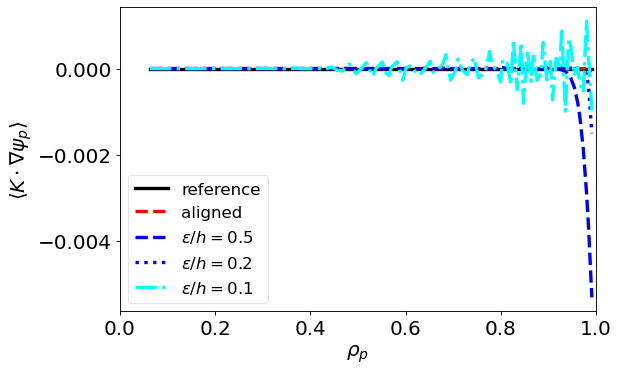

In [5]:
# plot q-profile for various methods
geometry_input = create_geometry_input()
with open ("compass_1X.json",'r') as f:
    params = json.load(f)
geometry_input["magnetic_field"]["params"] = params
geometry_input["width-factor"] = 0.5
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
frows = 1
fcols = 1

rho_p = ncin["rho_p"][:]
lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
rho = rho_p[:lcfs]
qprof_ana = np.zeros( lcfs)                             
                              
qprof_num_eta = ncin["CurvatureNablaBGradPsip_fsa"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa"][:lcfs]
qprof_num_avg = ncin["CurvatureNablaBGradPsip_fsa-avg"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa-avg"][:lcfs]


fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.618*5,frows*5),dpi= 80, facecolor='w', edgecolor='k')
# fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1*5,frows*5),dpi= 80, facecolor='w', edgecolor='k')

im = ax.plot(rho, qprof_ana, color = 'k', ls='-', lw=3, label='reference') 
im = ax.plot(rho, qprof_num_eta, color = 'red', ls='--', lw=3, label="aligned") 
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls='--', lw=3, label=r"$\varepsilon/h = 0.5$") 

print( "aligned ", getattr( ncin.variables["CurvatureNablaBGradPsip_fsa"], "time"))
time = getattr( ncin.variables["CurvatureNablaBGradPsip_fsa-avg"], "time")/2
timings = list()
timings.append(time)
print( r"$\varepsilon/h = 0.5$", time)
# the number 2 

ncin.close()
##########################################
geometry_input["width-factor"] = 0.2
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg = ncin["CurvatureNablaBGradPsip_fsa-avg"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg, color = 'blue', ls=':', lw=3, label=r"$\varepsilon/h = 0.2$")  
time = getattr( ncin.variables["CurvatureNablaBGradPsip_fsa-avg"], "time")/2
timings.append(time)
print( r"$\varepsilon/h = 0.2$", time)

##########################################
geometry_input["width-factor"] = .1
simfile = geometry_sim.create( geometry_input)
ncin = Dataset( simfile, 'r', format="NETCDF4")
qprof_num_avg = ncin["CurvatureNablaBGradPsip_fsa-avg"][:lcfs] + ncin["CurvatureKappaGradPsip_fsa-avg"][:lcfs]
im = ax.plot(rho, qprof_num_avg, color = 'cyan', ls='-.', lw=3, label=r"$\varepsilon/h = 0.1$")  
time = getattr( ncin.variables["CurvatureNablaBGradPsip_fsa-avg"], "time")/2
timings.append(time)
print( r"$\varepsilon/h = 0.1$", time)
print( "Average eps timings", np.mean(timings))
print( "Time for X-grid", getattr( ncin.variables["gridX"], "time"))
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=1,
                   fontsize='small',framealpha=0.5)
ax.set_xlabel( r"$\rho_p$")
ax.set_xlim([0,1])
ax.set_ylabel( r"$\langle K\cdot \nabla\psi_p\rangle$",rotation=90)
plt.tight_layout()
plt.savefig( "curvature.png", bbox_inches="tight")
plt.show()

In [6]:
# Construct the Gaussian weights on our grids
def gauss_weights1d( js) :
    n = js["npsi"]
    Nx = js["Npsi"]
    lx = 10 # length drops out in relative error BUT NOT ABSOLUTE
    hx = lx/Nx
    (x,w) = np.polynomial.legendre.leggauss(js[F"npsi"])
    weights1dX = np.tile( w, js["Npsi"])*hx/2
    return weights1dX

In [7]:
def compare_q( simfile) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    
    rho_p = ncin["rho_p"][:]
    lcfs = np.argmax( rho_p[np.where( rho_p < 1)])
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    weights = gauss_weights1d( gg)[:lcfs]
    dvdpsip = ncin["dvdpsip"][:lcfs]
    R_0 = geometry_input["magnetic_field"]["params"]["R_0"] 
    num = 1./4./np.pi**2/R_0*dvdpsip* ncin["BFieldP_fsa"][:lcfs]
    sol = ncin["q-profile"][:lcfs]
    diff = num - sol
#     norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff[:]**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( sol[:]**2*weights ))
    return norm_diff/ norm_sol

In [8]:
#define conversion function 
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x

def errorToString(x):
    return '%.2e' % x

In [9]:
# We could also lower Nx and Ny to get faster convergence to a constant
lines = list()
for Neta in [160,320,640,1280,2560,5120] :
    simulationfile = create_geometry_input()

    simulationfile["grid"]["Neta"] = Neta
    simfile =  geometry_sim.create( simulationfile)
    lines.append( [simulationfile["grid"]["n"]*Neta, compare_q( simfile)])

df = pd.DataFrame(lines, columns=["$N_\eta$", "error.q"])
name = "q"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\eta$"].shift(1)/df["$N_\eta$"]))
df.set_index(['$N_\eta$'], inplace=True) 
headers = [ "q-profile" ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_q-profile.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Existing simulation 06c109...5e5556.nc
Existing simulation 3330c5...99f2ef.nc
Existing simulation 768d72...e4bb73.nc
Existing simulation 2100b6...35910f.nc
Existing simulation 969ee6...2c47ee.nc
Existing simulation 9db31e...9de8c4.nc


/tmp/ipykernel_7863/1584074076.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


q-profile       
             error  order
$N_\eta$                 
480       5.26e-03    n/a
960       7.16e-04   2.88
1920      3.85e-05   4.22
3840      2.23e-06   4.11
7680      1.22e-09  10.84
15360     1.71e-12   9.48

In [10]:
def compare_dfs( simfile, rho_p_crit) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    
    rho_p = ncin["rho_p"][:]
    lcfs = np.argmax( rho_p[np.where( rho_p < rho_p_crit)])
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    weights = gauss_weights1d( gg)[:lcfs]

    num = ncin["SquareGradPsip_dfs"][:lcfs]
    sol = ncin["LaplacePsip_fsa"][:lcfs]
    diff = num - sol
#     norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( sol**2*weights ))
    return norm_diff/ norm_sol

In [11]:
# Test volume derivative
# We could also lower Nx and Ny to get faster convergence to a constant
lines = list()
for Npsi in [4,8,16,32,64,128] :
    simulationfile = create_geometry_input()
    simulationfile["grid"]["Nx"] = 80
    simulationfile["grid"]["Ny"] = 80
    simulationfile["grid"]["npsi"] = 3
    simulationfile["grid"]["Neta"] = 320
    simulationfile["grid"]["Npsi"] = Npsi
    simfile =  geometry_sim.create( simulationfile)
    lines.append( [simulationfile["grid"]["npsi"]*Npsi, compare_dfs( simfile, 1), compare_dfs(simfile,0.8)])

df = pd.DataFrame(lines, columns=["$N_\psi$", "error.dfsX", "error.dfsH" ])
names = ["dfsX","dfsH"]
for name in names:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
            np.log( df["$N_\psi$"].shift(1)/df["$N_\psi$"]))
df.set_index(['$N_\psi$'], inplace=True) 
headers = [ "$\langle \Delta\psi_p\rangle$ (incl. X-point)", "$\langle \Delta \psi_p\rangle$ (excl. X-point)" ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_dfs.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Existing simulation 697669...0b2a47.nc
Existing simulation 6cdf11...b13ac0.nc
Existing simulation f7209a...0677db.nc
Existing simulation 3330c5...99f2ef.nc
Existing simulation c3eace...59cb42.nc
Existing simulation eeb530...9d7758.nc


/tmp/ipykernel_7863/2286373726.py:29: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle \Delta\psi_p\rangle$ (incl. X-point)        \
                                                 error order   
$N_\psi$                                                       
12                                            9.09e-03   n/a   
24                                            1.46e-03  2.64   
48                                            6.63e-04  1.14   
96                                            4.96e-04  0.42   
192                                           2.98e-04  0.74   
384                                           9.43e-05  1.66   

         $\langle \Delta \psi_p\rangle$ (excl. X-point)        
                                                  error order  
$N_\psi$                                                       
12                                             4.31e-04   n/a  
24                                             1.05e-04  2.03  
48                                             2.83e-05  1.89  
96                                             7.91e-06  1.84  
192                                            2.11e-06  1.91  
384                                            5.43e-07  1.96

In [12]:
print( "FILE CONTENTS")
for v in ncin.variables:
    print( f"{v} {ncin.variables[v].shape}")

FILE CONTENTS
eta (1920,)
zeta (96,)
xcc (1920, 96)
ycc (1920, 96)
z (20,)
y (240,)
x (240,)
gridX (96,)
dvdpsip (96,)
psi_vol (96,)
psi_area (96,)
Psip_fsa (96,)
Psip_ifs (96,)
Psip_dfs (96,)
PsipR_fsa (96,)
PsipR_ifs (96,)
PsipR_dfs (96,)
PsipZ_fsa (96,)
PsipZ_ifs (96,)
PsipZ_dfs (96,)
PsipRR_fsa (96,)
PsipRR_ifs (96,)
PsipRR_dfs (96,)
PsipRZ_fsa (96,)
PsipRZ_ifs (96,)
PsipRZ_dfs (96,)
PsipZZ_fsa (96,)
PsipZZ_ifs (96,)
PsipZZ_dfs (96,)
Ipol_fsa (96,)
Ipol_ifs (96,)
Ipol_dfs (96,)
IpolR_fsa (96,)
IpolR_ifs (96,)
IpolR_dfs (96,)
IpolZ_fsa (96,)
IpolZ_ifs (96,)
IpolZ_dfs (96,)
Rho_p_fsa (96,)
Rho_p_ifs (96,)
Rho_p_dfs (96,)
LaplacePsip_fsa (96,)
LaplacePsip_ifs (96,)
LaplacePsip_dfs (96,)
Bmodule_fsa (96,)
Bmodule_ifs (96,)
Bmodule_dfs (96,)
InvB_fsa (96,)
InvB_ifs (96,)
InvB_dfs (96,)
LnB_fsa (96,)
LnB_ifs (96,)
LnB_dfs (96,)
GradLnB_fsa (96,)
GradLnB_ifs (96,)
GradLnB_dfs (96,)
Divb_fsa (96,)
Divb_ifs (96,)
Divb_dfs (96,)
B_R_fsa (96,)
B_R_ifs (96,)
B_R_dfs (96,)
B_Z_fsa (96,)
B_Z_ifs